# Example 3b: Rotational trap - Analyzing experimental data with pretrained network

Example code to analyze experimental data with DeepCalib using a pretrained network.

<strong>DeepCalib 1.0</strong><br/>
Enhanced force-field calibration via machine learning<br/>
version 1.0 - 27 April 2020<br/>
© Aykut Argun, Tobias Thalheim, Stefano Bo, Frank Cichos & Giovanni Volpe <br/>
[Soft Matter Lab](http://www.softmatterlab.org)

## 1. INIZIALIZATION

In [1]:
import DeepCalib

## 2. Import and visualize the experimental trajectory to be analyzed 

<a id="sec2"></a>

Here we import and visualize the experimental trajectory. 

Comments:
1. Make sure you define the same scaling functions for the inputs and the targets the same in the training file.  

Text(0.5, 0, '$x$ [μm]')

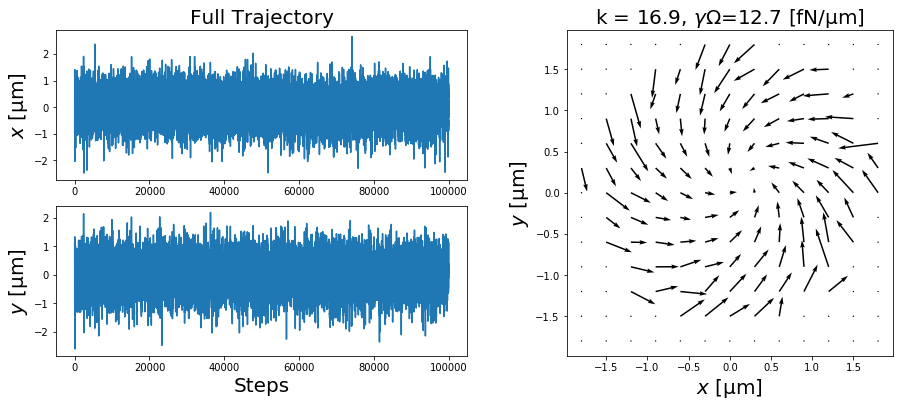

In [2]:
### Import the data 

import scipy.io as sci
data_name = 'Data_Example3b'
x = sci.loadmat(data_name)['x'].reshape(100000,)
y = sci.loadmat(data_name)['y'].reshape(100000,)

### Visualize the trajectory

import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(15, 6))
gs = fig.add_gridspec(15,10)
plt.subplot(gs[0:7,0:5])
plt.ylabel('$x$ [\u03BCm]',fontsize=20)                     
plt.title('Full Trajectory',fontsize=20)
plt.plot(x)
plt.subplot(gs[8:15,0:5])
plt.ylabel('$y$ [\u03BCm]',fontsize=20)
plt.xlabel('Steps',fontsize=20)
plt.plot(y)

### Evaluate the data

from numpy.linalg import inv
import numpy as np
r = np.array([x,y])[:,0:-1] *1e-6
f = np.diff([x,y])*6*1.4*np.pi*0.001*1e-13/1e-2
JF=np.matmul(np.matmul(inv(np.matmul(r,r.transpose())), r),
             f.transpose()).transpose()   
m=-1/2*(JF[0,1]-JF[1,0])*1e9     # Measured rotational component by FORMA (fN / \mu m)
k=-1/2*(JF[0,0]+JF[0,0])*1e9     # Measured radial component by FORMA (fN / \mu m)
dx = np.diff(x);
dy = np.diff(y); 
x = x[:-1]
y = y[:-1]
ux = np.zeros((13,13))
uy = np.zeros((13,13))
l = (np.arange(14)-7)*.3
for i in range(l.size-1):
    for j in range(l.size-1):
            ind = ( x<l[i+1] ) & ( x>l[i] ) & ( y<l[j+1] ) & ( y>l[j] ) 
            if sum(ind)>20:
                ux[j,i] = np.mean(dx[ind])
                uy[j,i] = np.mean(dy[ind])

### Visualize the measured truths 

plt.subplot(gs[:,6:10])
plt.quiver(np.meshgrid(l[1:],l[1:])[0],
           np.meshgrid(l[1:],l[1:])[1],
           ux,
           uy)
plt.title('k = ' + str(np.round(k,1)) + ', ' + \
          '$\gamma \Omega$=' + str(np.round(m,1)) \
          +' [fN/\u03BCm]',fontsize=20)
plt.ylabel('$y$ [\u03BCm]',fontsize=20)
plt.xlabel('$x$ [\u03BCm]',fontsize=20)


In [5]:
### Analyze the data

from keras.models import load_model
import numpy as np
from scipy.constants import Boltzmann as kB
network = load_model('Network_Example_3a.h5')
predictions_k = []
predictions_m = []
oversamp = 4
nmeas = 100
steps = int((x.size-1000*oversamp)/nmeas)
slength = 1000*oversamp
for i in range(nmeas):
    x_crop = [y[(i*steps):(i*steps+slength):oversamp],x[(i*steps):(i*steps+slength):oversamp]]       
    predicted_k, predicted_m = DeepCalib.predict(network, x_crop)[0]
    predictions_k.append(predicted_k)
    predictions_m.append(predicted_m)

k0 = 2e-8                  # Reference stiffness [N m^-1]
M0 = 2e-8                  # Reference rotational coefficient [N m^-1]
rescale_targets = lambda scaled_k, scaled_m: [np.exp(scaled_k) * k0, 
                                              scaled_m*M0] # Inverse of targets_scaling  

[predictions_k, predictions_m] = rescale_targets(*np.array([predictions_k, predictions_m]))

(0, 50)

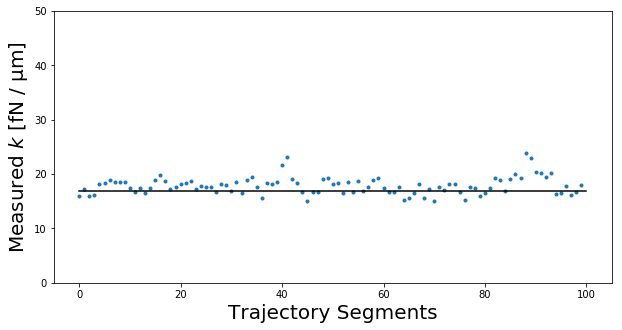

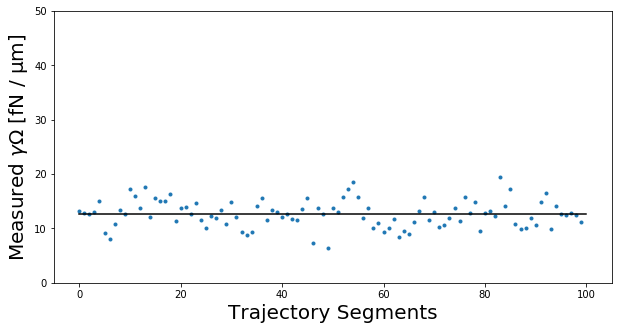

In [6]:
fig = plt.figure(figsize=(10, 5))
plt.plot(predictions_k*1e9,'.')
plt.plot([0, nmeas], np.array([1, 1])*k,color='black')
plt.xlabel('Trajectory Segments',fontsize=20)
plt.ylabel('Measured $k$ [fN / \u03BCm]',fontsize=20)
plt.ylim([0, 50])

fig = plt.figure(figsize=(10, 5))
plt.plot(predictions_m*1e9,'.')
plt.plot([0, nmeas], np.array([1, 1])*m,color='black')
plt.xlabel('Trajectory Segments',fontsize=20)
plt.ylabel('Measured $\gamma \Omega$ [fN / \u03BCm]',fontsize=20)
plt.ylim([0, 50])
